In [1]:
#% matplotlib inline
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import re
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import matplotlib.pyplot as plt


## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
#Read the file and add new columns helpfulnessnumerator and helpfulnessdenominator
reviews = pd.read_csv('sample30.csv')

reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
reviews.shape

(30000, 15)

In [4]:
reviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [5]:
#Dropping columns not adding value to analysis
rv_recom=reviews[['id','name','reviews_username','reviews_rating']]
rv_recom = rv_recom.rename(columns={'reviews_username': 'userID', 'id': 'prod_ID','name': 'prod_name',
                                                 'reviews_rating': 'rating' })

In [6]:
# Create single coolumn for Review Title and Review test 
#rv_recom['user_reviews']=str(rv_recom.reviews_title) + str(rv_recom.reviews_text)
#rv_recom.drop(columns=['reviews_title','reviews_text'],inplace=True)
rv_recom.head()

,prod_ID,prod_name,userID,rating
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,walker557,1


In [7]:
rv_recom.isnull().sum()

prod_ID       0
prod_name     0
userID       63
rating        0
dtype: int64

In [8]:
#drop rows having any blank cell
rv_recom=rv_recom[~rv_recom.userID.isnull()==True]

In [9]:
rv_recom.shape

(29937, 4)

In [10]:
#Total 24914 Users
rv_recom.userID.value_counts()

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
                     ..
barbs8                1
thous5                1
picturesorelse        1
soultouch             1
royswoman             1
Name: userID, Length: 24914, dtype: int64

In [11]:
#Total 271 Items/products
rv_recom.prod_name.value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8525
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
Fantasy Fields Lil' Sports Fan Step Stool - Teamson                                  1
Lite Source Reiko 1 Light Table Lamp - Orange                                        1
Bodycology Nourishing Body Cream, Pretty In Paris                                    1
Roommates No Place Like Home Peel Stick Wall Decals                                  1
Progresso Traditional Chicken Rice With Vegetables Soup                              1
Name: prod_name, Length: 271, dtype: int64

Text(0, 0.5, 'Count')

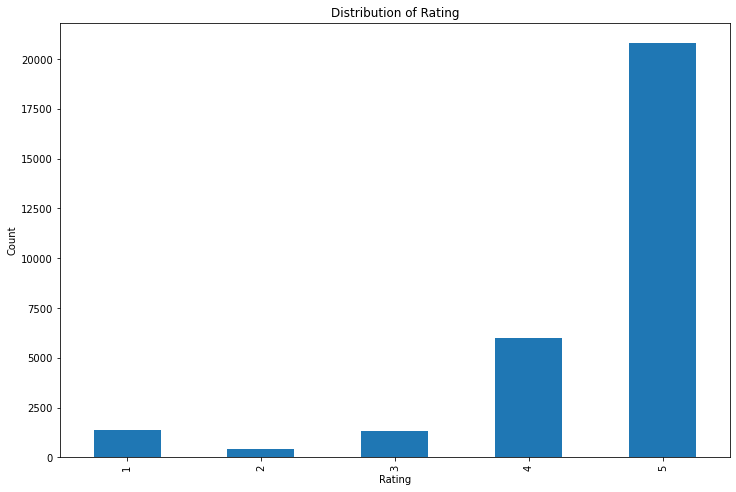

In [27]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(data['Rating'])
rv_recom['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0, 0.5, 'Number of Reviews')

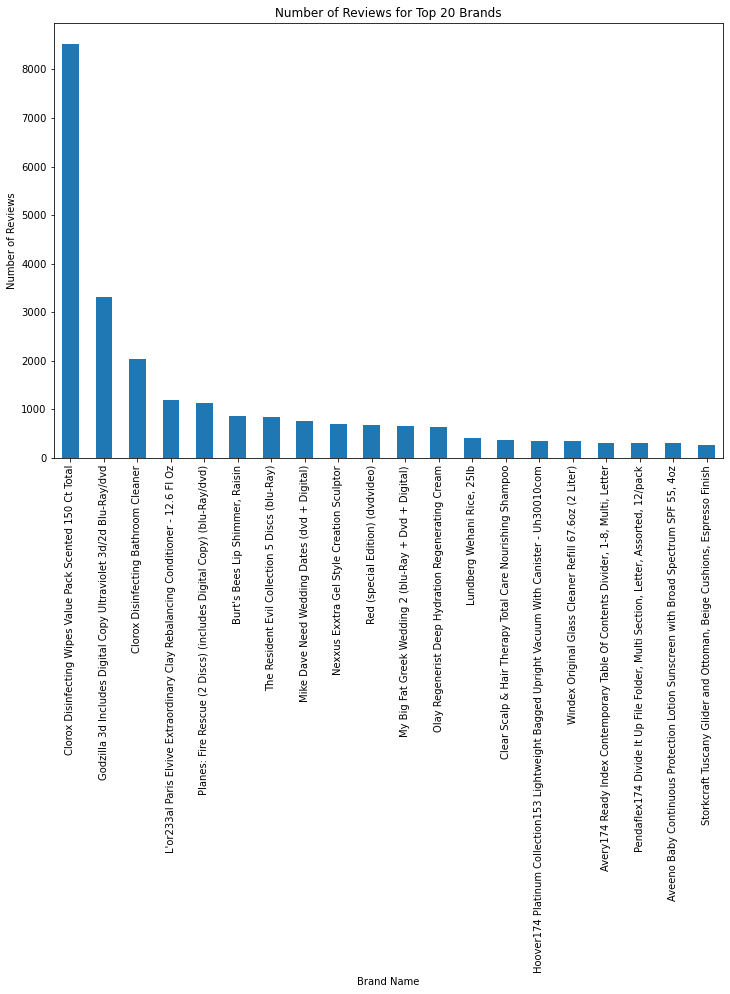

In [18]:
## PLOT NUMBER OF REVIEWS FOR TOP 20 BRANDS  

brands = rv_recom["prod_name"].value_counts()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

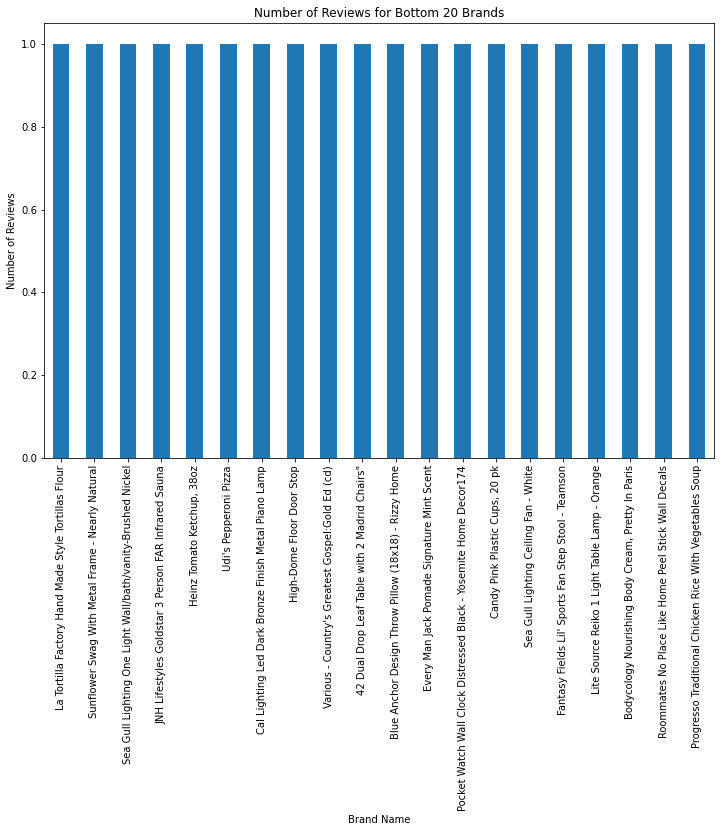

In [22]:
## PLOT NUMBER OF REVIEWS FOR BOTTOM 20 BRANDS  

brands = rv_recom["prod_name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[-20:].plot(kind='bar')
plt.title("Number of Reviews for Bottom 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

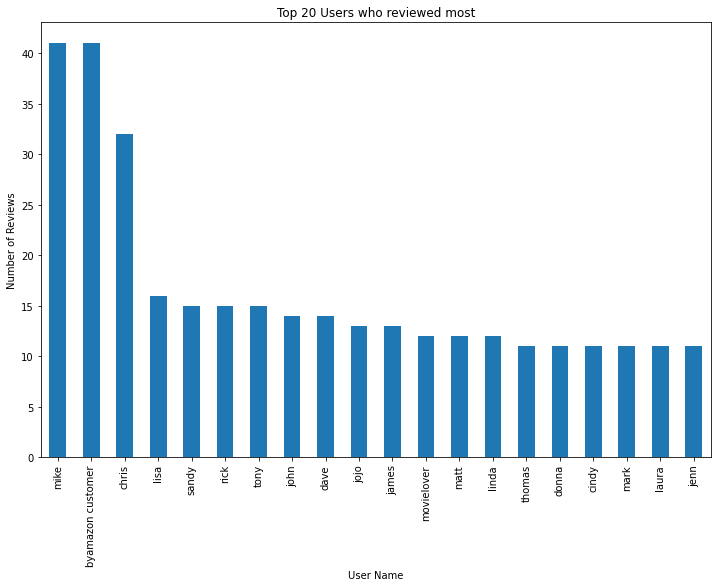

In [23]:
## PLOT TOP 20 users who reviewed most

brands = rv_recom["userID"].value_counts()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Top 20 Users who reviewed most")
plt.xlabel('User Name')
plt.ylabel('Number of Reviews')